In [3]:
import pickle
import torch
import matplotlib.pyplot as plt
import glob
import random
import pandas as pd
import seaborn as sns
import numpy as np
from adabmDCA.utils import get_device, get_dtype, get_mask_save

import sys
sys.path.append('selex_dca')
from selex_dca import *

## Load saved data

In [4]:
data = []

for filepath in glob.iglob('saved/*.pkl'):
    with open(filepath, 'rb') as f:
        data.append(pickle.load(f))

data = [data[i] for i in [1,2,0]]

(experiment_id_all, round_ids_all, params_all, params_t_all,
    logselect_t_all, counts_all, inverse_indices_all, num_seq_all) = zip(*data)

In [5]:
def allequal(x):
    return x.count(x[0]) == len(x)

assert(allequal(round_ids_all))

round_ids = round_ids_all[0]
ts = range(len(round_ids))

## Compare parameters across experiments

### Couplings

In [6]:
Js = [params_all[t]["couplings_ps"] for t in ts]
Js_flat = [J.reshape(-1) for J in Js]
MJ = torch.stack(Js_flat).numpy()
np.corrcoef(MJ)

array([[1.        , 0.17474234, 0.21144967],
       [0.17474234, 1.        , 0.15653979],
       [0.21144967, 0.15653979, 1.        ]])

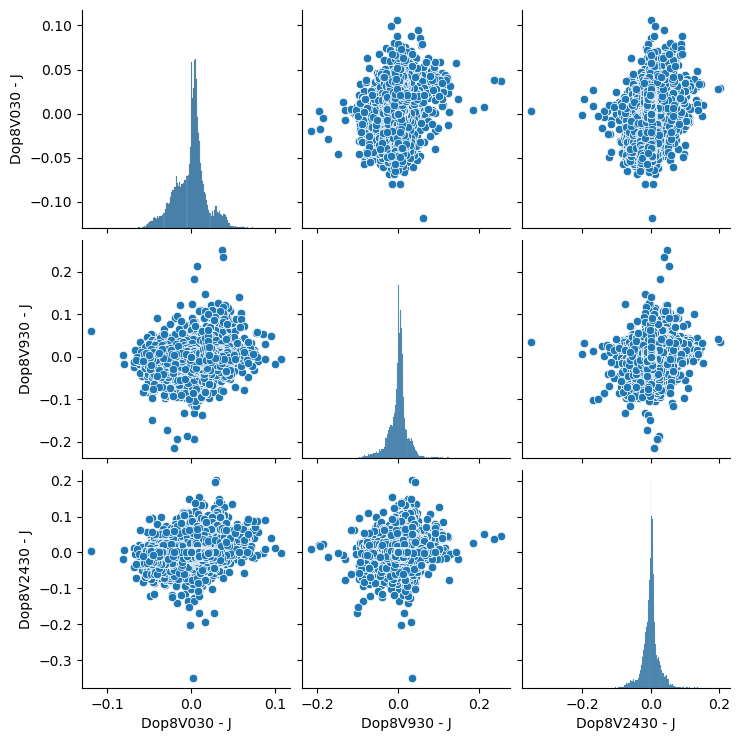

In [116]:
names = [exp + " - J" for exp in experiment_id_all]
df_J = pd.DataFrame(MJ.transpose(), columns=names)
sns.pairplot(df_J)
plt.savefig('J.png')

### Biases ps

In [8]:
hs = [params_all[t]["bias_ps"] for t in ts]
hs_flat = [h.reshape(-1) for h in hs]
Mh = torch.stack(hs_flat).numpy()
np.corrcoef(Mh)

array([[ 1.        , -0.27034701, -0.4731885 ],
       [-0.27034701,  1.        , -0.21569531],
       [-0.4731885 , -0.21569531,  1.        ]])

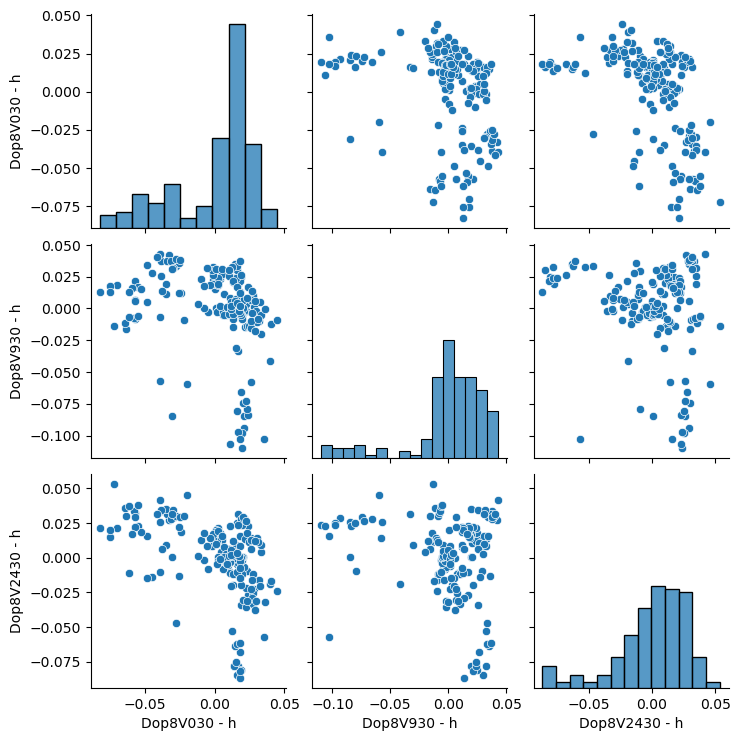

In [9]:
names = [exp + " - h" for exp in experiment_id_all]
df_h = pd.DataFrame(Mh.transpose(), columns=names)
sns.pairplot(df_h)

### Biases Ns0

In [10]:
ks = [params_all[t]["bias_Ns0"] for t in ts]
ks_flat = [k.reshape(-1) for k in ks]
Mk = torch.stack(ks_flat).numpy()
np.corrcoef(Mk)

array([[ 1.        ,  0.05814461, -0.07356289],
       [ 0.05814461,  1.        , -0.1059038 ],
       [-0.07356289, -0.1059038 ,  1.        ]])

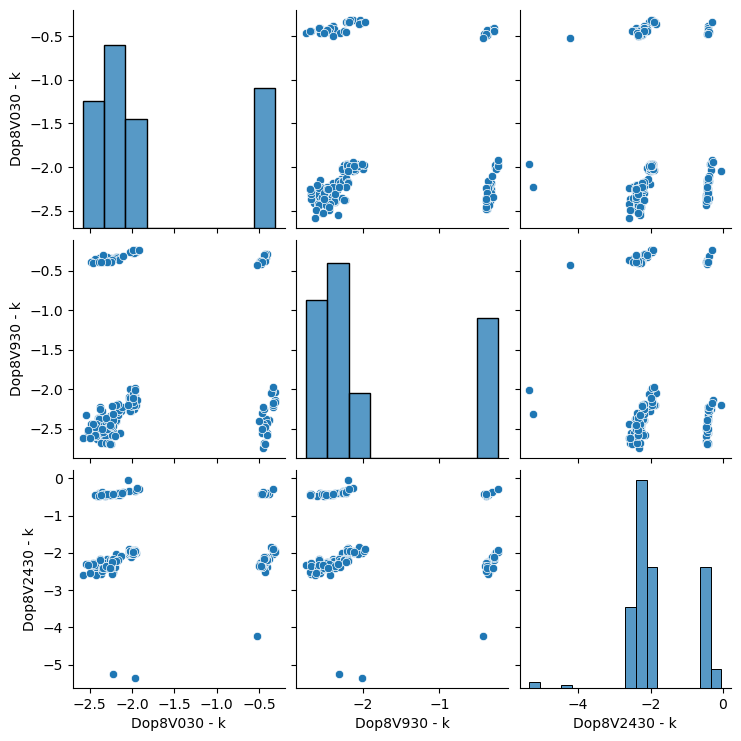

In [11]:
names = [exp + " - k" for exp in experiment_id_all]
df_k = pd.DataFrame(Mk.transpose(), columns=names)
sns.pairplot(df_k)

## Compare Nst with log-abundances

In [12]:
# def vectors_for_scatterplot(counts, inverse_indices, C, logselect_t):
#     counts_all = counts[inverse_indices]
#     idx_unique_over_thresh = counts_all >= C
#     x = logselect_t[inverse_indices][idx_unique_over_thresh]
#     y = torch.log(counts_all[idx_unique_over_thresh])
#     return x, y

def vectors_for_scatterplot(counts, inverse_indices, logNst_thresh, logselect_t):
    counts_all = counts[inverse_indices]
    idx_unique_over_thresh = logselect_t[inverse_indices] >= logNst_thresh
    x = logselect_t[inverse_indices][idx_unique_over_thresh]
    y = torch.log(counts_all[idx_unique_over_thresh])
    return x, y

C_all = [10, 5, 10]
logNst_thresh_all = [-30, -25, -25]
N = 10**4

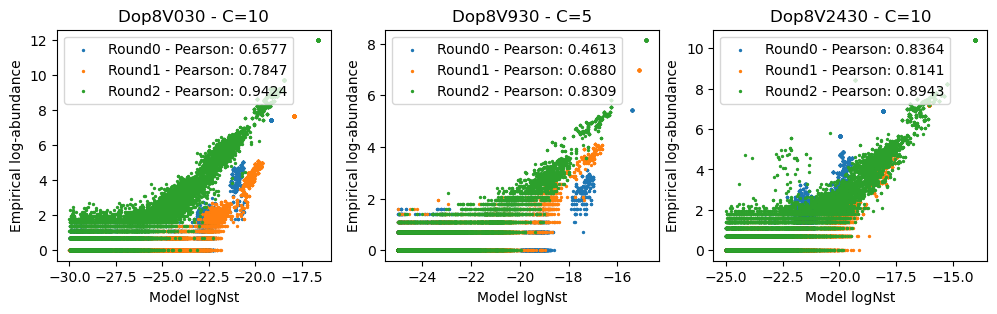

In [13]:
n_exp = len(experiment_id_all)
pl, axes = plt.subplots(1,n_exp, figsize=(4*n_exp,3))

for a in range(n_exp):
    counts = counts_all[a]
    inverse_indices = inverse_indices_all[a]
    C = C_all[a]
    logselect_t = logselect_t_all[a]
    experiment_id = experiment_id_all[a]
    logNst_thresh = logNst_thresh_all[a]
    ax = axes[a]
    
    X, Y = zip(*[vectors_for_scatterplot(counts[t], inverse_indices[t], logNst_thresh, logselect_t[t])
                 for t in ts]) 
    pearson = [torch.corrcoef(torch.stack((x, y)))[0,1] for (x,y) in zip(X,Y)]
    for t in ts:
        x = X[t]; y = Y[t]
        idx = random.sample(range(len(x)),min(N, len(x)))
        ax.scatter(x[idx], y[idx], label=f"Round{t} - Pearson: {pearson[t]:.{4}f}", s=2)
        ax.set_xlabel("Model logNst")
        ax.set_ylabel("Empirical log-abundance")
        ax.set_title(f"{experiment_id}")
    ax.legend()

Compare with chain model:
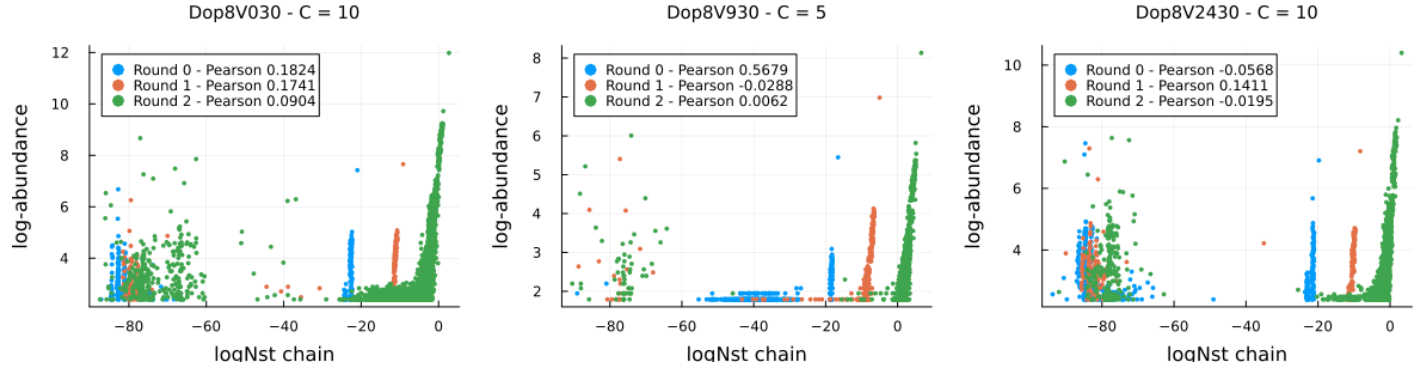

Compare with indep sites:

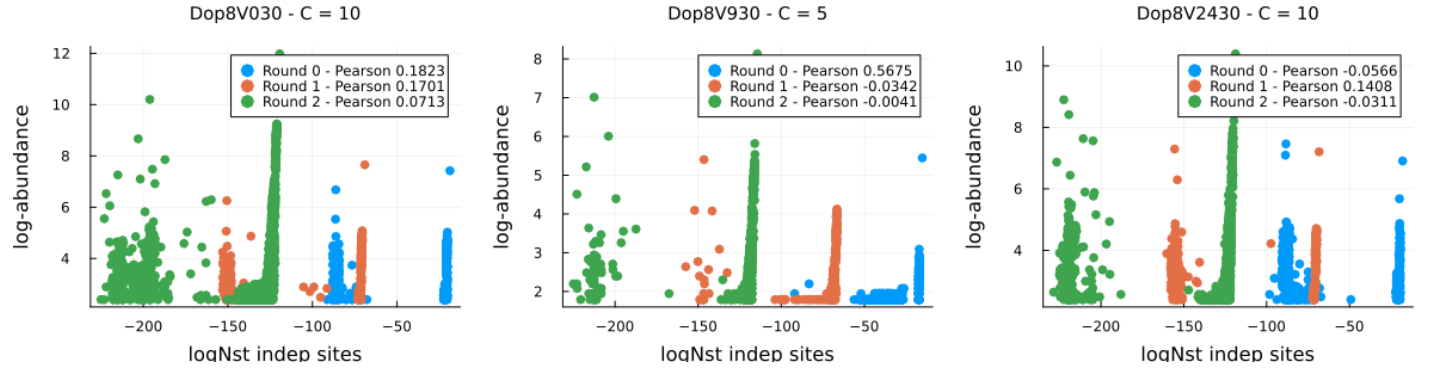

## Compare log-abundances across datasets

In [14]:
device = get_device("")
dtype = get_dtype("float32")

Running on CPU


In [15]:
sequences_all = [[sequences_from_file(experiment_id, round_id, device) 
                  for round_id in round_ids] for experiment_id in experiment_id_all];

In [40]:
def compute_logNst(sequences, params, round_ids):
    t = range(len(round_ids))
    sequences_unique, inverse_indices, counts = zip(*[
        torch.unique(sequences[t], dim=0, return_inverse=True, return_counts=True)
        for t in ts])
    sequences_unique_oh = [one_hot(s) for s in sequences_unique]

    params_t = [get_params_at_round(params, t) for t in ts]
    logNst = [-adabmDCA.statmech.compute_energy(sequences_unique_oh[t], params_t[t])
                   for t in ts]
    return logNst, inverse_indices, counts

def vectors_for_scatterplot_single_t(logNst, counts, logNst_thresh, inverse_indices):
    idx_unique_over_thresh = logNst >= logNst_thresh
    x = logNst[idx_unique_over_thresh]
    y = torch.log(counts[idx_unique_over_thresh])
    return x, y

In [41]:
logNst_all, inverse_indices_all, counts_all = zip(*[compute_logNst(sequences_all[n], params_all[n], round_ids)
                                    for n in range(n_exp)])

In [42]:
X,Y = zip(*[zip(*[vectors_for_scatterplot_single_t(logNst_all[n][t], counts_all[n][t], logNst_thresh_all[n],
                                                  inverse_indices_all[n][t])
                  for t in ts]) for n in range(n_exp)])

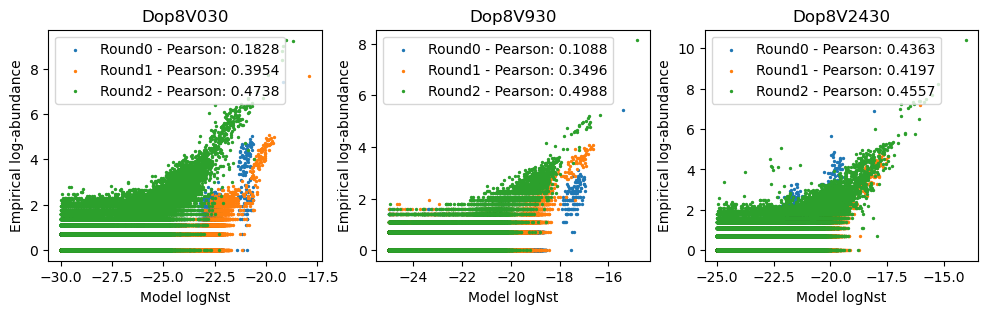

In [53]:
N = 10**5
pl, axes = plt.subplots(1,n_exp, figsize=(4*n_exp,3))

for n in range(n_exp):
    ax = axes[n]
    for t in ts:
        pearson = torch.corrcoef(torch.stack((X[n][t], Y[n][t])))[0,1]
        x = X[n][t]; y = Y[n][t]
        idx = random.sample(range(len(x)),min(N, len(x)))
        ax.scatter(x[idx], y[idx], label=f"Round{t} - Pearson: {pearson:.{4}f}", s=2)
        ax.set_xlabel("Model logNst")
        ax.set_ylabel("Empirical log-abundance")
        ax.set_title(f"{experiment_id_all[n]}")
    ax.legend()

In [87]:
sequences_unique_all, inverse_indices_all, counts_all = zip(*[zip(*[
    torch.unique(sequences_all[n][t], dim=0, return_inverse=True, return_counts=True)
    for t in ts]) for n in range(n_exp)])

In [96]:
def get_params_ps(params):
    return {"bias": params["bias_ps"], "coupling_matrix": params["couplings_ps"]}

def compute_logps(sequences_unique, params, round_ids):
    t = range(len(round_ids))
    sequences_unique_oh = [one_hot(s) for s in sequences_unique]
    logps = [-adabmDCA.statmech.compute_energy(sequences_unique_oh[t], params)
                   for t in ts]
    return logps

In [101]:
logps_cross

In [103]:
logps_cross = [[compute_logps(sequences_unique_all[m], get_params_ps(params_all[n]), round_ids)
    for n in range(n_exp)] for m in range(n_exp)]

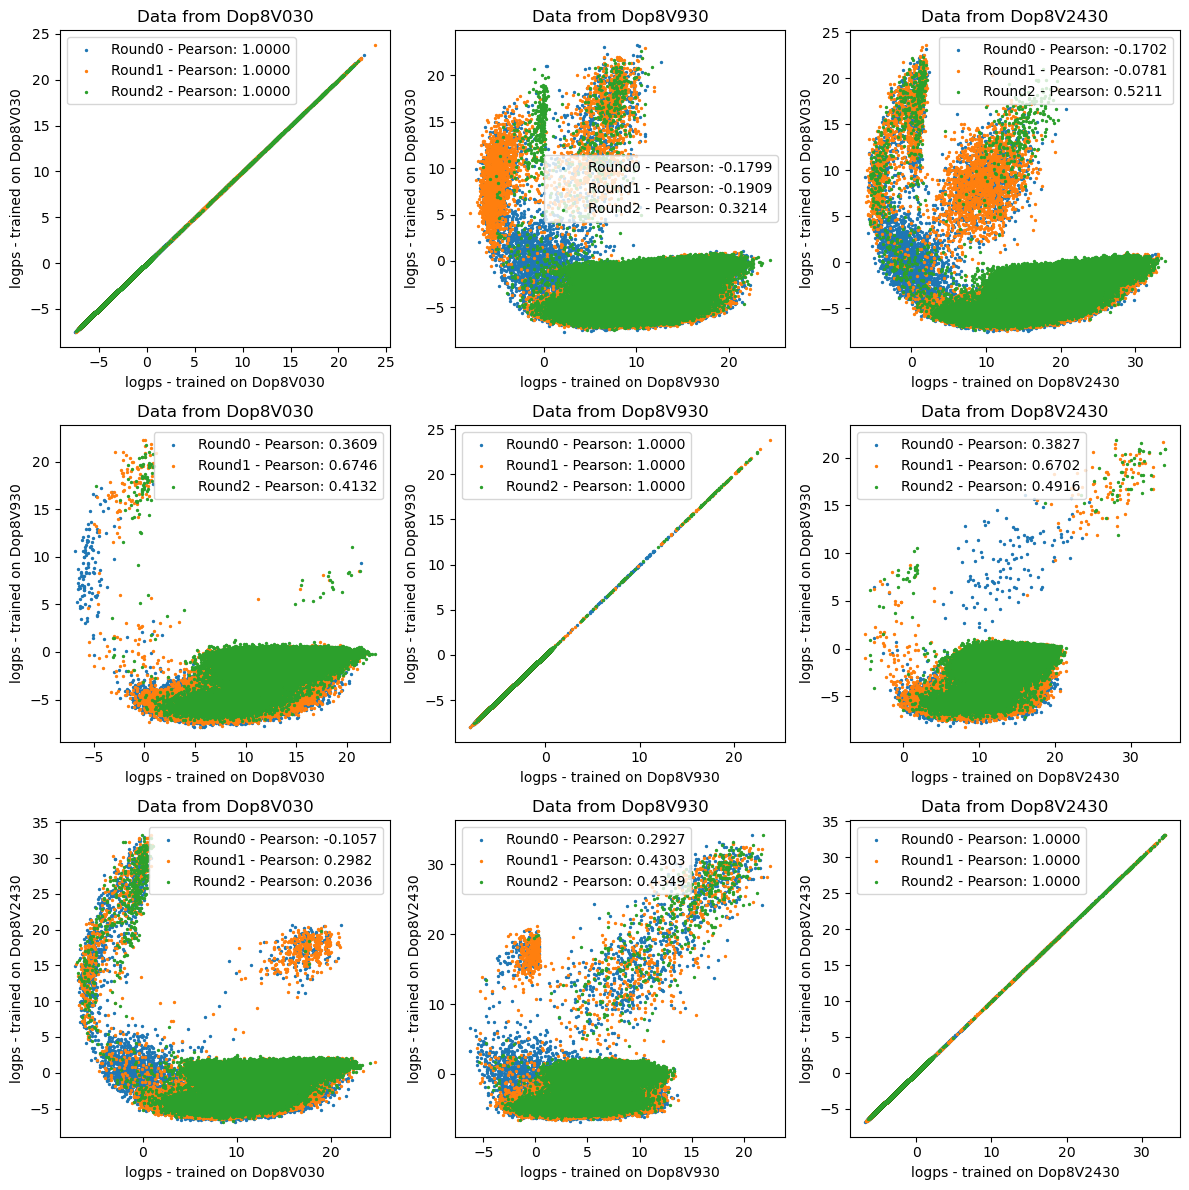

In [112]:
N = 10**5
pl, axes = plt.subplots(n_exp,n_exp, figsize=(4*n_exp,4*n_exp))

for m in range(n_exp):
    for n in range(n_exp):
        ax = axes[m,n]
        # if m >= n:
        for t in ts:
            x = logps_cross[m][n][t]
            y = logps_cross[m][m][t]
            pearson = torch.corrcoef(torch.stack((x,y)))[0,1]            
            idx = random.sample(range(len(x)),min(N, len(x)))
            ax.scatter(x[idx], y[idx], label=f"Round{t} - Pearson: {pearson:.{4}f}", s=2)
            ax.set_xlabel(f"logps - trained on {experiment_id_all[n]}")
            ax.set_ylabel(f"logps - trained on {experiment_id_all[m]}")
            ax.set_title(f"Data from {experiment_id_all[n]}")
        ax.legend()
plt.tight_layout()
plt.savefig('logps_cross.png')

In [83]:
logNst_cross, inverse_indices_cross, counts_cross = zip(*[zip(*[
    compute_logNst(sequences_all[m], params_all[n], round_ids)
    for n in range(n_exp)]) for m in range(n_exp)])

In [84]:
[[len(logNst_cross[m][n][1]) for n in range(n_exp)] for m in range(n_exp)]

[[4844197, 4844197, 4844197],
 [3300712, 3300712, 3300712],
 [5101046, 5101046, 5101046]]

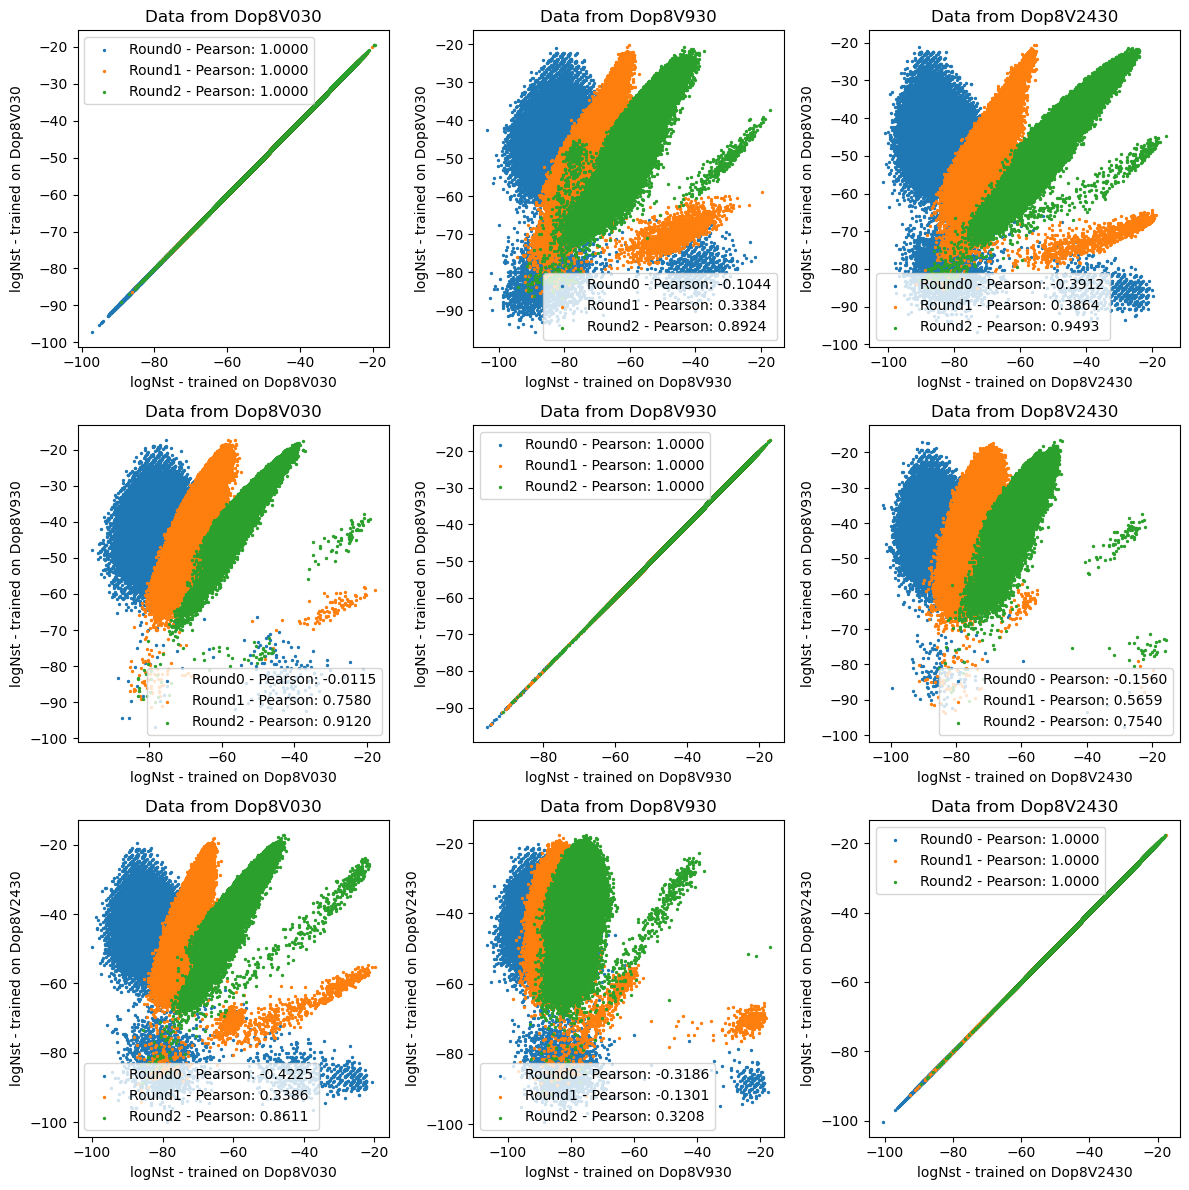

In [113]:
N = 10**5
pl, axes = plt.subplots(n_exp,n_exp, figsize=(4*n_exp,4*n_exp))

for m in range(n_exp):
    for n in range(n_exp):
        ax = axes[m,n]
        for t in ts:
            x = logNst_cross[m][n][t]
            y = logNst_cross[m][m][t]
            pearson = torch.corrcoef(torch.stack((x,y)))[0,1]            
            idx = random.sample(range(len(x)),min(N, len(x)))
            ax.scatter(x[idx], y[idx], label=f"Round{t} - Pearson: {pearson:.{4}f}", s=2)
            ax.set_xlabel(f"logNst - trained on {experiment_id_all[n]}")
            ax.set_ylabel(f"logNst - trained on {experiment_id_all[m]}")
            ax.set_title(f"Data from {experiment_id_all[n]}")
        ax.legend()
plt.tight_layout()
plt.savefig('logNst_cross.png')